In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_fscore_support

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

sns.set()

In [5]:
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')
start_time = datetime.now()

In [35]:
def assessment(f_data, f_y_feature, f_x_feature, f_index=-1):
    """
    Develops and displays a histogram and a scatter plot for a dependent / independent variable pair from
    a dataframe and, optionally, highlights a specific observation on the plot in a different color (red).
    
    Also optionally, if an independent feature is not informed, the scatterplot is not displayed.
    
    Keyword arguments:
    
    f_data      Tensor containing the dependent / independent variable pair.
                Pandas dataframe
    f_y_feature Dependent variable designation.
                String
    f_x_feature Independent variable designation.
                String
    f_index     If greater or equal to zero, the observation denoted by f_index will be plotted in red.
                Integer
    """
    for f_row in f_data:
        if f_index >= 0:
            f_color = np.where(f_data[f_row].index == f_index,'r','g')
            f_hue = None
        else:
            f_color = 'b'
            f_hue = None
    
    f_fig, f_a = plt.subplots(1, 2, figsize=(16,4))
    
    f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='orangered')
    f_chart1.set_xlabel(f_x_feature,fontsize=10)
    
    if f_index >= 0:
        f_chart2 = plt.scatter(f_data[f_x_feature], f_data[f_y_feature], c=f_color, edgecolors='w')
        f_chart2 = plt.xlabel(f_x_feature, fontsize=10)
        f_chart2 = plt.ylabel(f_y_feature, fontsize=10)
    else:
        f_chart2 = sns.scatterplot(x=f_x_feature, y=f_y_feature, data=f_data, hue=f_hue, legend=False)
        f_chart2.set_xlabel(f_x_feature,fontsize=10)
        f_chart2.set_ylabel(f_y_feature,fontsize=10)

    plt.show()


def correlation_map(f_data, f_feature, f_number):
    """
    Develops and displays a heatmap plot referenced to a primary feature of a dataframe, highlighting
    the correlation among the 'n' mostly correlated features of the dataframe.
    
    Keyword arguments:
    
    f_data      Tensor containing all relevant features, including the primary.
                Pandas dataframe
    f_feature   The primary feature.
                String
    f_number    The number of features most correlated to the primary feature.
                Integer
    """
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    
    with sns.axes_style("darkgrid"):
        f_fig, f_ax = plt.subplots(figsize=(40, 20))
        f_map = sns.heatmap(f_correlation, mask=f_mask, vmin=-1, vmax=1, square=True,
                            center=0, cmap="RdYlBu")
    plt.show()

In [7]:
# Importing the dataset
dataset = pd.read_csv('input/WinnipegDataset.txt')
dataset = dataset.sample(frac=1)

In [8]:
dataset.head()

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
165144,4,-20.2000,-29.476,-17.9540,-22.424,-18.284,-22.129,-2.24620,-9.2760,-11.5220,...,1.00000,1.00000,2.0,0.0,1.0,0.0,0.0,-0.0,1.0,1.0
24025,1,-9.9985,-17.950,-6.9736,-10.547,-8.366,-10.811,-3.02490,-7.9520,-10.9770,...,0.33333,-0.28677,0.0,0.0,1.0,0.0,0.0,-0.0,1.0,1.0
144185,4,-22.0400,-32.843,-20.6340,-25.731,-20.161,-25.082,-1.40610,-10.8020,-12.2080,...,0.65432,0.18898,3.0,0.0,1.0,0.0,0.0,-0.0,1.0,1.0
26918,1,-9.7164,-18.914,-10.1670,-12.250,-10.085,-12.351,0.45061,-9.1977,-8.7471,...,0.40741,0.31623,0.0,0.0,1.0,0.0,0.0,-0.0,1.0,1.0
278869,6,-17.6900,-25.095,-18.7040,-21.729,-16.776,-22.312,1.01400,-7.4057,-6.3917,...,0.33333,-0.55000,1.0,0.0,1.0,0.0,0.0,-0.0,1.0,1.0


In [9]:
class_share = pd.Series(100 * dataset.label.value_counts(normalize=True)).sort_index()
print('Class share\n')
for i in range(0,7):
    print(f'Class {class_share.index[i]}: {class_share.iloc[i]:.2f} %')

Class share

Class 1: 12.02 %
Class 2: 1.10 %
Class 3: 23.22 %
Class 4: 22.73 %
Class 5: 14.46 %
Class 6: 26.11 %
Class 7: 0.35 %


Text(0, 0.5, 'Stosunek [%]')

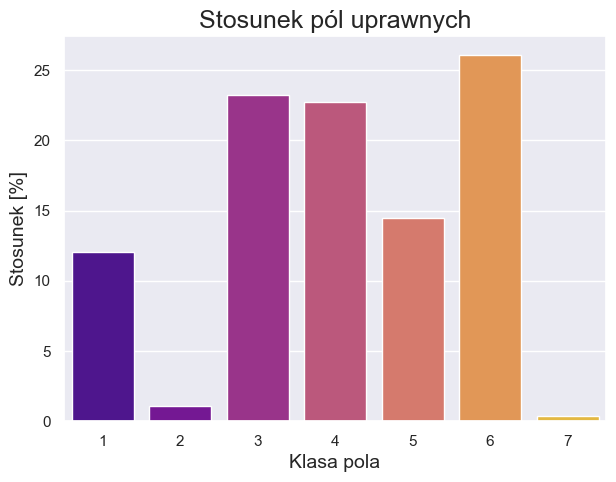

In [14]:
fig, ax = plt.subplots(figsize = (7, 5))
sns.barplot(ax=ax, x = class_share.index, y = class_share, palette = "plasma")
plt.title("Stosunek pól uprawnych", fontsize = 18)
plt.xlabel("Klasa pola", fontsize = 14)
plt.ylabel("Stosunek [%]", fontsize = 14)

In [15]:
wysoko_skorelowane_pary = []
wysoko_skorelowane_cechy_do_usunięcia = []

macierz_korelacji = dataset.corr().abs()
upper_matrix = macierz_korelacji.where(np.triu(np.ones(macierz_korelacji.shape), k = 1).astype(np.bool))
for row in range(upper_matrix.shape[0]):
    for column in range(upper_matrix.shape[1]):
        if upper_matrix.iloc[row, column] > 0.95:
            wysoko_skorelowane_pary.append([row, column, upper_matrix.iloc[row, column]])
            
print(f'Liczba par wysokoskorelowanych cech: {len(wysoko_skorelowane_pary)}')
        

Liczba par wysokoskorelowanych cech: 117


In [17]:
wysoko_skorelowane_pary = pd.DataFrame(wysoko_skorelowane_pary).sort_values(by=[2], ascending=False)
wysoko_skorelowane_pary.columns = ['feature_1', 'feature_2', 'correl']
wysoko_skorelowane_pary.head(10)

,feature_1,feature_2,correl
4,2,39,1.000000
38,51,88,1.000000
109,151,153,1.000000
45,54,86,1.000000
8,5,37,1.000000
102,142,147,1.000000
113,156,157,0.998716
13,7,15,0.995524
10,6,38,0.995455
60,62,79,0.995254


In [28]:
wysoko_skorelowane_cechy_do_usunięcia = [column for column in upper_matrix.columns if any(upper_matrix[column] > 0.95)]
dataset = dataset.drop(dataset[wysoko_skorelowane_cechy_do_usunięcia], axis = 1)                                                                        

In [29]:
nr_features = dataset.shape[1] - 1
print(f'Optymalizowana liczba cech: {nr_features}')

Optymalizowana liczba cech: 102


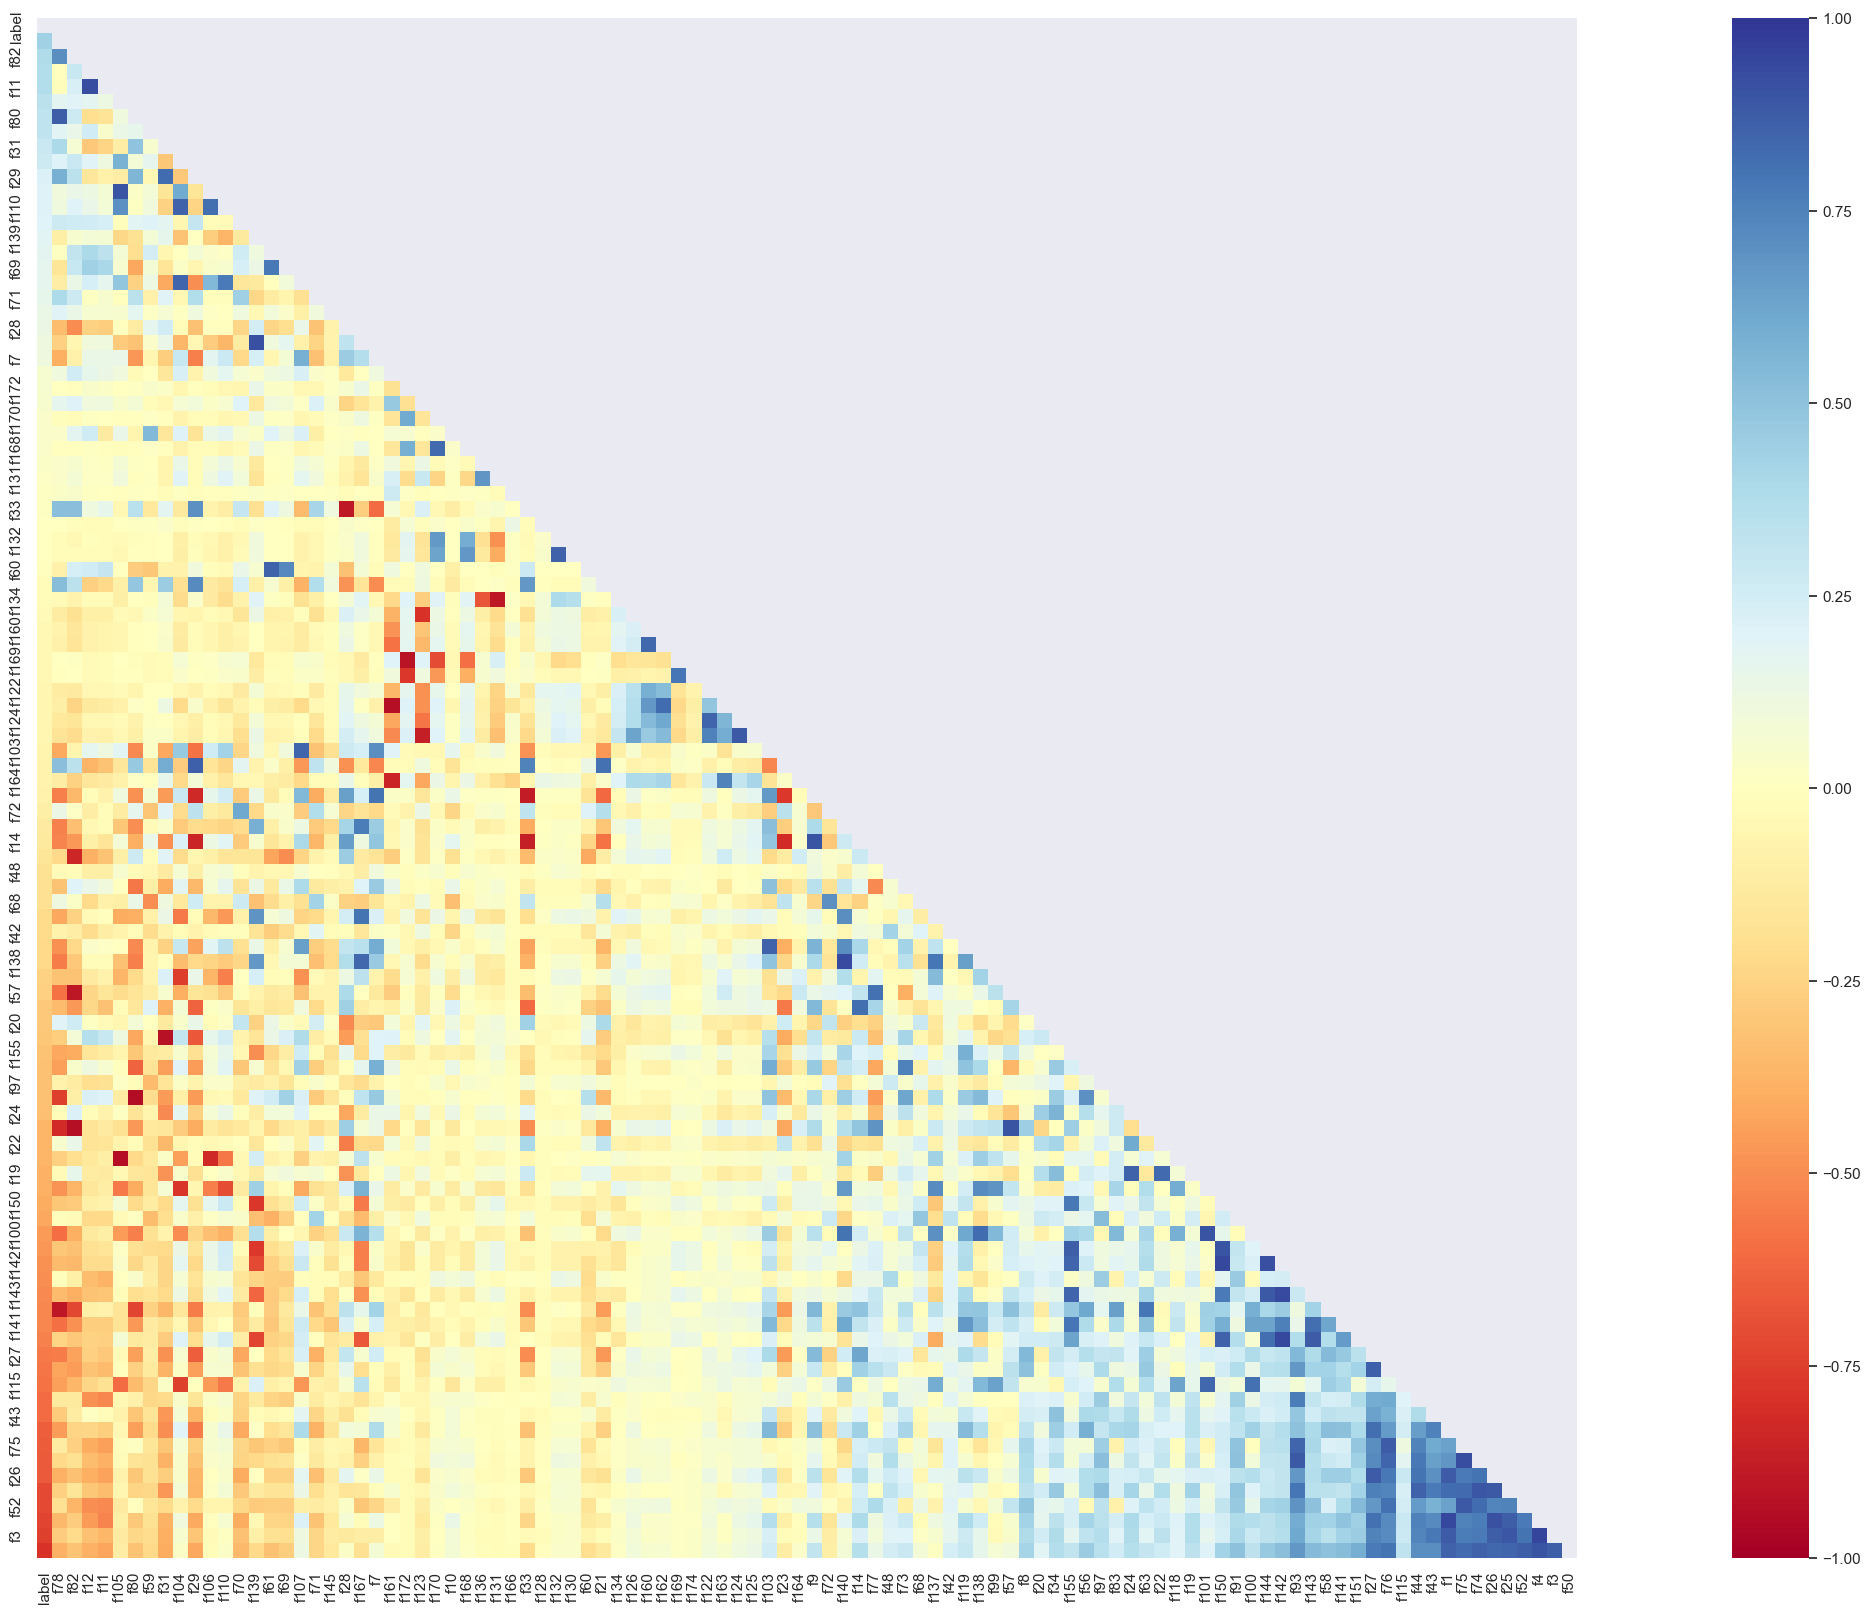

In [36]:
correlation_map(dataset, 'label', nr_features)

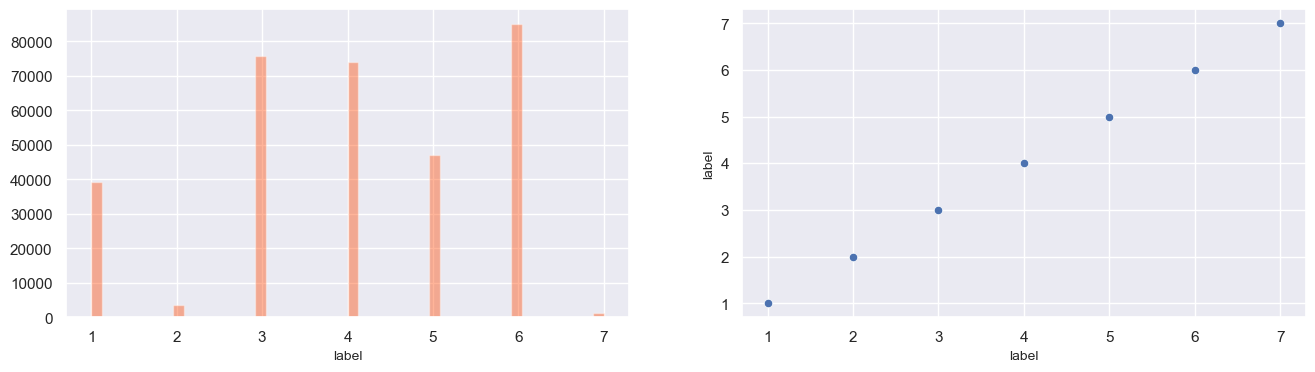

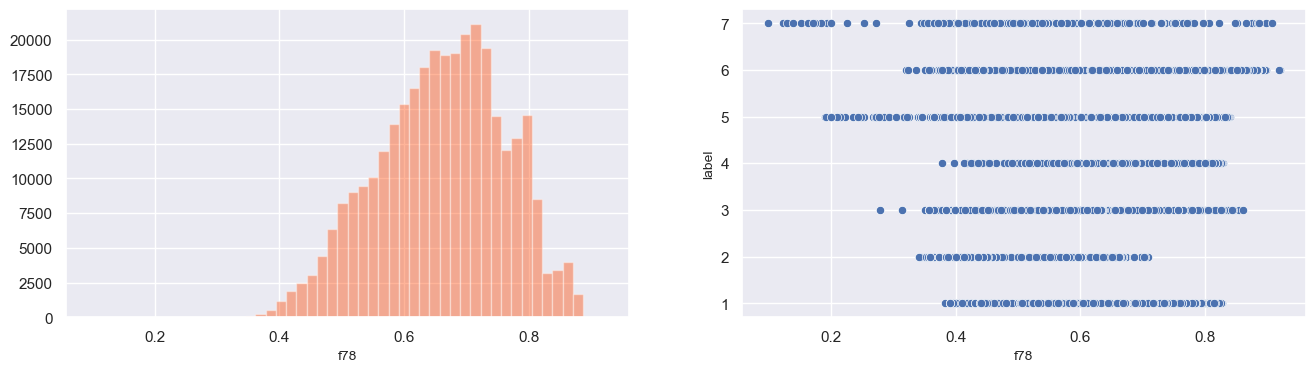

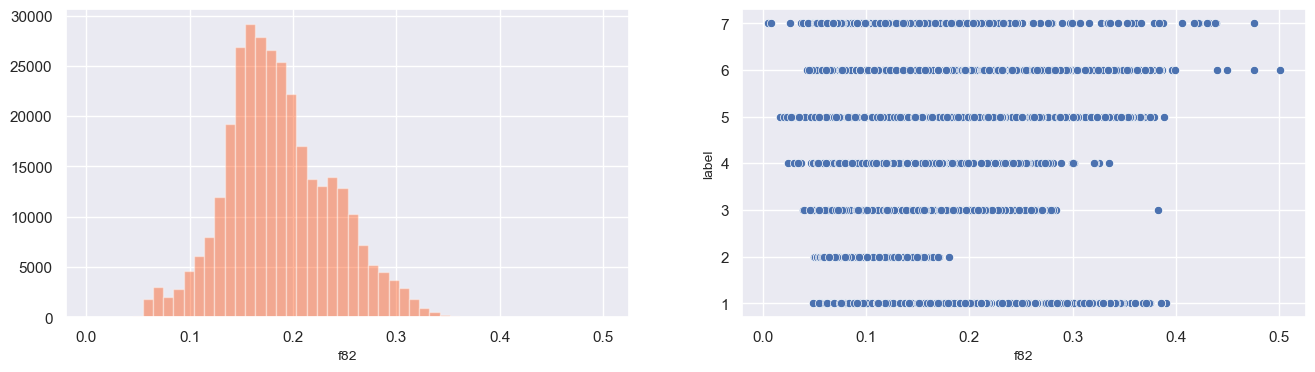

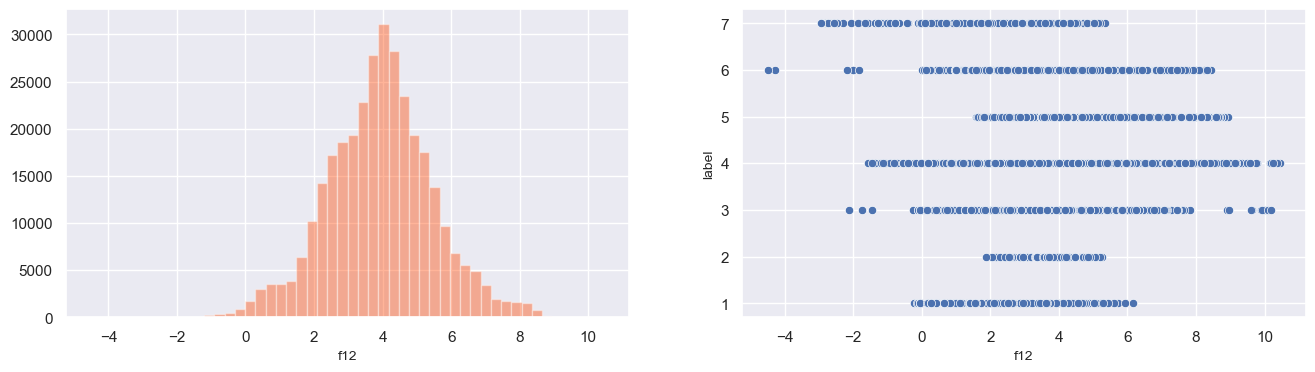

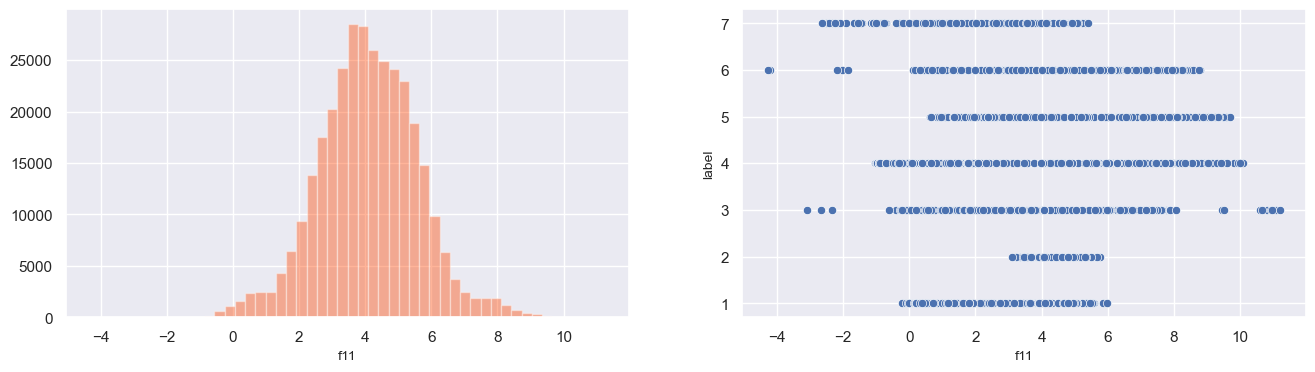

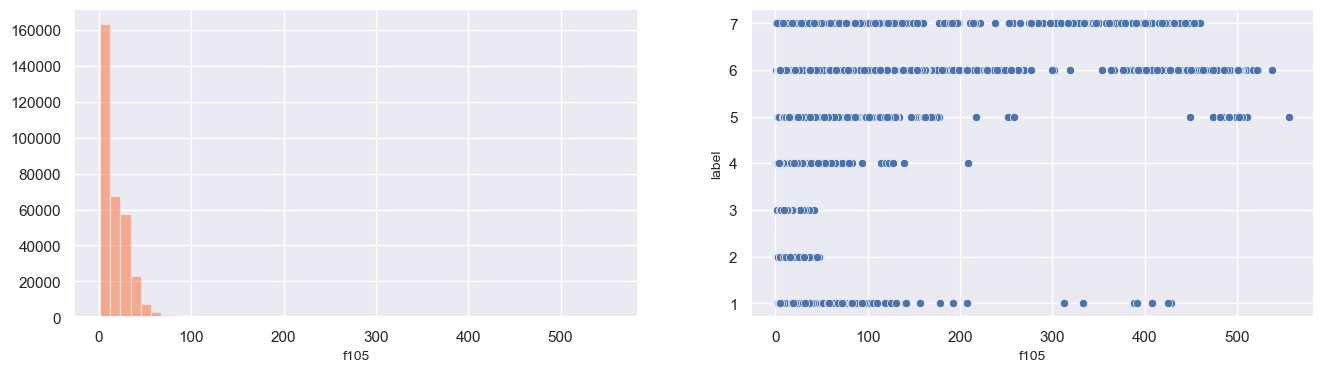

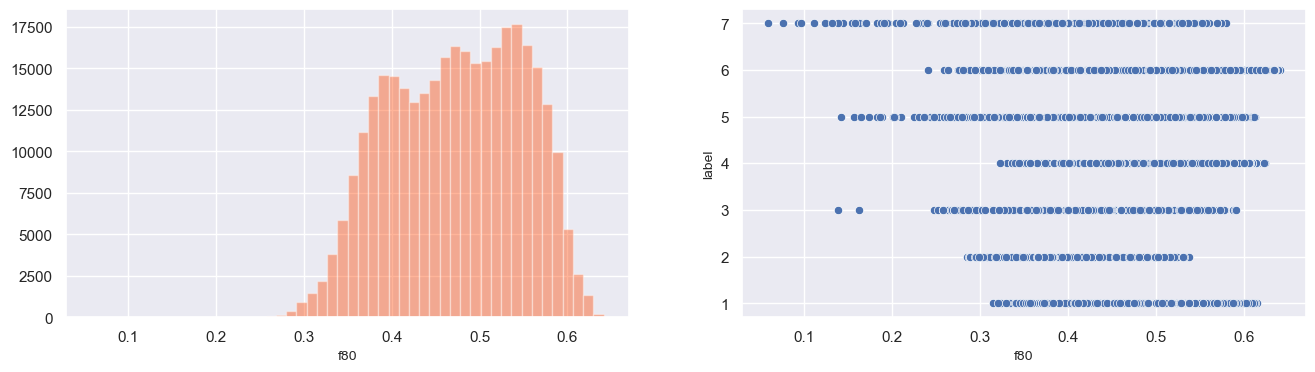

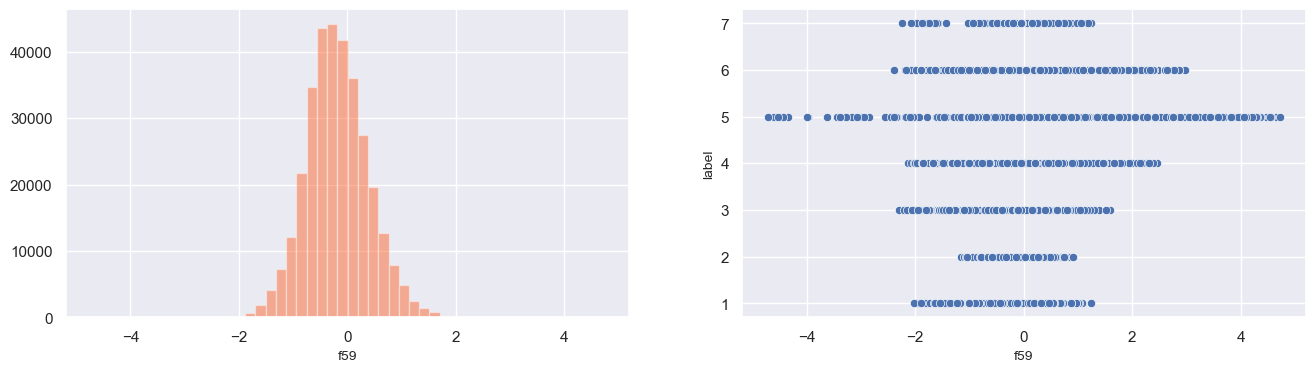

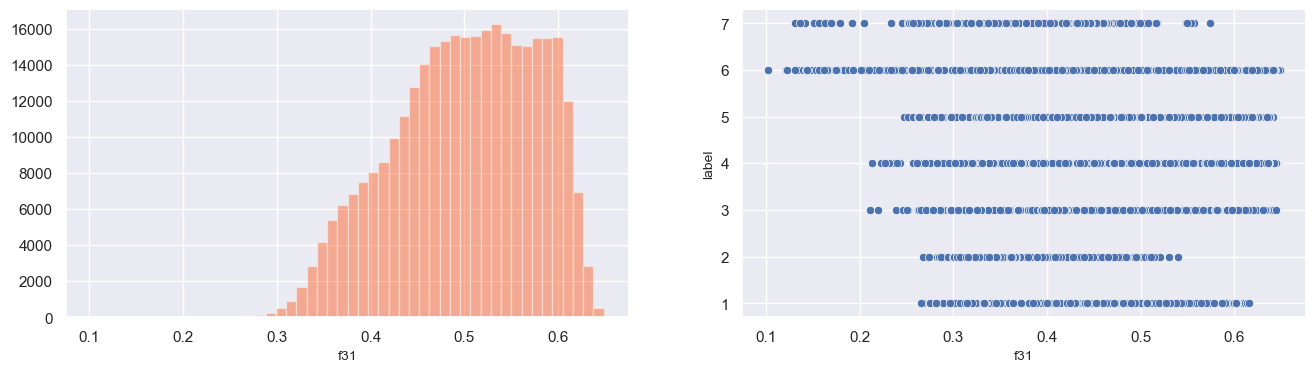

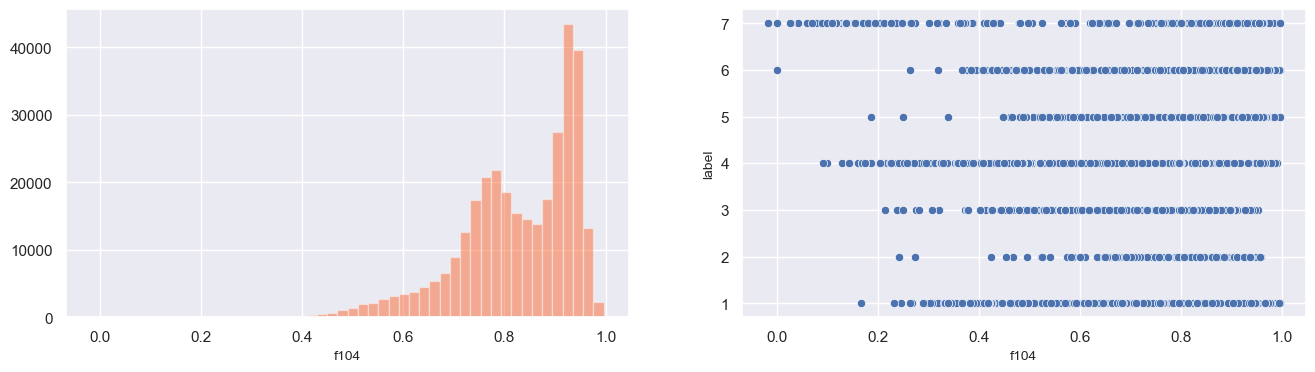

In [37]:
most_correlated_features = dataset.corr().nlargest(10,'label')['label'].index

for column in most_correlated_features:
    assessment(dataset, 'label', column, -1)

In [40]:
X = dataset.iloc[:, 1:]
y = dataset.iloc[:, 0:1]

In [41]:
train_size = round(0.8 * len(X))

In [42]:
X_train = X.iloc[:train_size, :].values
y_train = y.iloc[:train_size]

X_test = X.iloc[train_size:, :].values
y_test = y.iloc[train_size:]

In [43]:
class_count = pd.Series(y_test.label.value_counts()).sort_index()
print('Class count - Test labels\n')
for i in range(0,7):
    print(f'Class {class_count.index[i]}: {class_count.iloc[i]}')

Class count - Test labels

Class 1: 7869
Class 2: 751
Class 3: 15322
Class 4: 14663
Class 5: 9264
Class 6: 17071
Class 7: 227


In [46]:
y_train_rf = y_train.label.values
y_test_rf = y_test.label.values

y_train_ann = pd.get_dummies(y_train.label).values
y_test_ann = pd.get_dummies(y_test.label).values

In [47]:
# skalowanie
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [59]:
random_forest_classifier = RandomForestClassifier(n_estimators=100, n_jobs=4)

random_forest_classifier.fit(X_train, y_train_rf)

RandomForestClassifier(n_jobs=4)

In [60]:
y_pred_rf = random_forest_classifier.predict(X_test)

In [61]:
print(f'Przewidziana klasa: {y_pred_rf[0]}')
print(f'Rzeczywista klasa: {y_test_rf[0]}')

Przewidziana klasa: 4
Rzeczywista klasa: 4


In [62]:
# ANN, sztuczna sieć neuronowa
ann_classifier = Sequential()

# warstwa inputowa i pierwsza warstwa
ann_classifier.add(Dense(units = 204, kernel_initializer = 'uniform', activation = 'relu', input_dim = 102))
ann_classifier.add(Dropout(0.1))

# druga warstwa Dense
ann_classifier.add(Dense(units = 204, kernel_initializer = 'uniform', activation = 'relu'))
ann_classifier.add(Dropout(0.1))

# trzecia warstwa Dense
ann_classifier.add(Dense(units = 102, kernel_initializer = 'uniform', activation = 'relu'))
ann_classifier.add(Dropout(0.1))

# Output warstwa
ann_classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax'))

# Model compilation

optim = Adam(learning_rate=0.0005)

ann_classifier.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [64]:
ann_train_history = ann_classifier.fit(X_train, y_train_ann, batch_size = 64, epochs = 40, verbose=0)

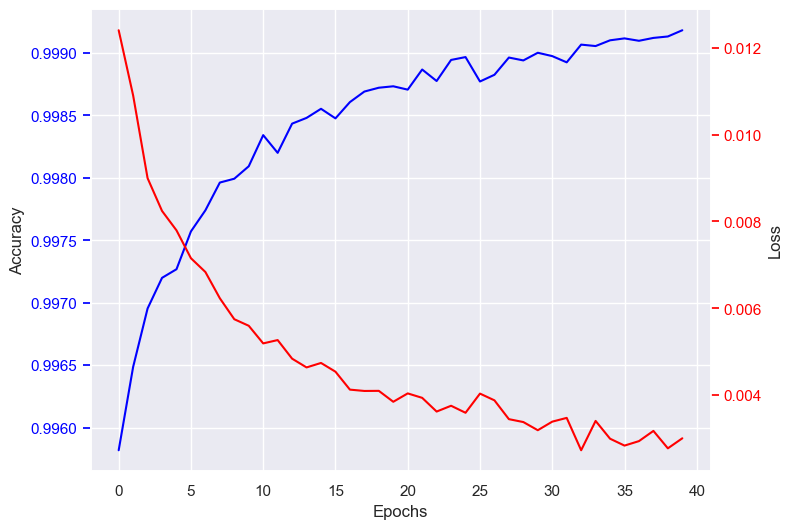

In [79]:
fig, ax1 = plt.subplots(figsize=(8,6))
sns.set_style("darkgrid")
ax2 = ax1.twinx()
ax1.plot(ann_train_history.history['accuracy'], color='blue')
ax2.plot(ann_train_history.history['loss'], color='red')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='y', colors='blue')
ax2.set_ylabel('Loss')
ax2.tick_params(axis='y', colors='red')
ax2.grid(False)
plt.show()

In [72]:
y_pred_ann = ann_classifier.predict(X_test)
for i in range(len(y_pred_ann)):
    for j in range(7):
        if y_pred_ann[i][j] == y_pred_ann[i].max():
            y_pred_ann[i][j] = 1
        else:
            y_pred_ann[i][j] = 0
y_pred_ann = y_pred_ann.astype(int)

2037/2037 [==============================] - 3s 2ms/step


In [73]:
print(f'Przewidziane: {y_pred_ann[0]}')
print(f'Rzeczywiste: {y_test_ann[0]}')

Przewidziane: [0 0 0 1 0 0 0]
Rzeczywiste: [0 0 0 1 0 0 0]


In [74]:
#Random Forest
rf_cm = np.zeros((7,7))

In [75]:
rf_pred_correct = 0
rf_pred_incorrect = 0
for i in range(len(y_test)):
    rf_index_test = y_test_rf[i] - 1
    rf_index_pred = y_pred_rf[i] - 1
    rf_cm[rf_index_test][rf_index_pred] += 1
    if rf_index_test == rf_index_pred:
        rf_pred_correct += 1
    else:
        rf_pred_incorrect += 1

In [76]:
rf_cmatrix = pd.DataFrame(rf_cm.astype(int),
                          index = ['Corn', 'Pea', 'Canola', 'Soy', 'Oat', 'Wheat', 'Broadleaf'],
                          columns = ['Corn', 'Pea', 'Canola', 'Soy', 'Oat', 'Wheat', 'Broadleaf'])
rf_cmatrix

,Corn,Pea,Canola,Soy,Oat,Wheat,Broadleaf
Corn,7849,0,5,9,1,3,2
Pea,0,749,0,2,0,0,0
Canola,2,0,15306,5,2,7,0
Soy,8,0,5,14620,14,16,0
Oat,6,0,6,12,9171,62,7
Wheat,0,0,4,17,36,17013,1
Broadleaf,4,0,2,0,1,2,218


In [77]:
rf_accuracy = accuracy_score(y_test_rf, y_pred_rf)
rf_precision, rf_recall, rf_f_score, rf_support = precision_recall_fscore_support(y_test_rf, y_pred_rf, average='macro')
print(f'Accuracy: {rf_accuracy * 100:.2f} %')
print(f'Precision: {rf_precision * 100:.2f} %')
print(f'Recall: {rf_recall * 100:.2f} %')
print(f'F-Score: {rf_f_score * 100:.2f} %')

Accuracy: 99.63 %
Precision: 99.11 %
Recall: 99.11 %
F-Score: 99.11 %


In [78]:
print('Accuracy per class\n')
for i in range(len(rf_cmatrix)):
    class_accuracy = rf_cmatrix.iloc[i,i] / rf_cmatrix.sum(axis=0)[i]
    print(f'{rf_cmatrix.columns[i]}: {class_accuracy*100:.2f} %')

Accuracy per class

Corn: 99.75 %
Pea: 100.00 %
Canola: 99.86 %
Soy: 99.69 %
Oat: 99.41 %
Wheat: 99.47 %
Broadleaf: 95.61 %


In [70]:
#deep learning
ann_cm = np.zeros((7,7))

In [80]:
ann_pred_correct = 0
ann_pred_incorrect = 0
for i in range(len(y_test_ann)):
    if y_pred_ann[i].sum() > 0:
        ann_index_test = np.where(y_test_ann[i] == 1)[0][0]
        ann_index_pred = np.where(y_pred_ann[i] == 1)[0][0]
        ann_cm[ann_index_test][ann_index_pred] += 1
        if ann_index_test == ann_index_pred:
            ann_pred_correct += 1
        else:
            ann_pred_incorrect += 1


In [81]:
ann_cmatrix = pd.DataFrame(ann_cm.astype(int),
                           index = ['Corn', 'Pea', 'Canola', 'Soy', 'Oat', 'Wheat', 'Broadleaf'],
                           columns = ['Corn', 'Pea', 'Canola', 'Soy', 'Oat', 'Wheat', 'Broadleaf'])
ann_cmatrix

,Corn,Pea,Canola,Soy,Oat,Wheat,Broadleaf
Corn,7859,0,1,1,5,1,2
Pea,0,751,0,0,0,0,0
Canola,1,0,15309,5,1,5,1
Soy,3,0,1,14648,9,2,0
Oat,1,0,1,9,9238,14,1
Wheat,0,0,3,17,33,17018,0
Broadleaf,1,0,1,0,1,0,224


In [82]:
ann_accuracy = accuracy_score(y_test_ann, y_pred_ann)
ann_precision, ann_recall, ann_f_score, ann_support = precision_recall_fscore_support(y_test_ann, y_pred_ann, average='macro')
print(f'Accuracy: {ann_accuracy * 100:.2f} %')
print(f'Precision: {ann_precision * 100:.2f} %')
print(f'Recall: {ann_recall * 100:.2f} %')
print(f'F-Score: {ann_f_score * 100:.2f} %')

Accuracy: 99.82 %
Precision: 99.61 %
Recall: 99.68 %
F-Score: 99.64 %


In [83]:
ann_accuracy = accuracy_score(y_test_ann, y_pred_ann)
ann_precision, ann_recall, ann_f_score, ann_support = precision_recall_fscore_support(y_test_ann, y_pred_ann, average='macro')
print(f'Accuracy: {ann_accuracy * 100:.2f} %')
print(f'Precision: {ann_precision * 100:.2f} %')
print(f'Recall: {ann_recall * 100:.2f} %')
print(f'F-Score: {ann_f_score * 100:.2f} %')

Accuracy: 99.82 %
Precision: 99.61 %
Recall: 99.68 %
F-Score: 99.64 %


In [84]:
print('Accuracy per class\n')
for i in range(len(ann_cmatrix)):
    class_accuracy = ann_cmatrix.iloc[i,i] / ann_cmatrix.sum(axis=0)[i]
    print(f'{ann_cmatrix.columns[i]}: {class_accuracy*100:.2f} %')

Accuracy per class

Corn: 99.92 %
Pea: 100.00 %
Canola: 99.95 %
Soy: 99.78 %
Oat: 99.47 %
Wheat: 99.87 %
Broadleaf: 98.25 %
